# WILT

Import of necessary modules

In [89]:
import numpy as np
import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
from tkcalendar import Calendar
import pandas as pd
import matplotlib.pyplot as plt

Ask the user for the number of days to calculate

Constants

In [90]:
rho_w = 1  # Density of water g/cm^3
C_w = 4.18  # Specific heat capacity J/(g*K)
epsilon = 0.96
kelvin =  273.15

Define the dimensions of the basin and the initial water temperature and volume

In [91]:
days = int(input("Enter the number of days to calculate: "))
basin_width = float(input("Width of the floodplain in meters"))
basin_length = float(input("Length of the floodplain in meters"))
current_water_level = float(input("The initial water level in meters"))
max_water_level = float(input("The maximal water level in meters"))
water_temp = float(input("The initial water temperature in degrees celcius")) + kelvin
current_basin_volume = basin_width * basin_length * current_water_level
Max_basin_volume = basin_width * basin_length * max_water_level
basin_surface_area = basin_width * basin_length

In [92]:
initial_situ = "The current water level is " + str(current_water_level) + " meters,\n" \
               "The current water temperature is " + str(water_temp) + " °K,\n" \
               "The surface area is " + str(basin_surface_area/1e6) + " km\u00b2,\n"\
               "The volume is " + str(current_basin_volume/1e9) + " km\u00b3\n"\

print(initial_situ)

The current water level is 1.5 meters,
The current water temperature is 288.15 °K,
The surface area is 0.0015 km²,
The volume is 2.25e-06 km³



Calculate the initial water level based on the volume and surface area of the basin

In [93]:
z_w = np.zeros(days)
z_w[0] = current_water_level * 100# cm

Initialize water surface temperature

In [94]:
t_w = np.zeros(days)
t_w[0] = water_temp  # Assign starting water temperature of 15 degrees
t_w_C = np.zeros(days)
t_w_C[0] = water_temp - kelvin

Define a function to get data from a CSV file or from user input

In [95]:
def get_data(filename_prompt, value_prompt, column_name):
    if input(filename_prompt) == 'y':
        # If the user wants to supply a CSV file, open a file dialog to select the file
        root = tk.Tk()
        root.withdraw()
        root.call('wm', 'attributes', '.', '-topmost', True)
        path = filedialog.askopenfilename()

        # Read the data from the CSV file and set the column names
        data = pd.read_csv(path, header=0, delimiter=",", usecols=[0, 1])
        data.columns = ['Day', f'{column_name}']
    else:
        # If the user doesn't want to supply a CSV file, ask for a single value and
        # create a DataFrame with that value for each day
        value = float(input(value_prompt + ": "))
        data = pd.DataFrame({'Day': range(1, days + 1), f'{column_name}': [value] * days})
    return data

Get the inflow, outflow, solar radiation, and outside temperature data

In [96]:
# Get the inflow, outflow, solar radiation, and outside temperature data
inflow_data = get_data("Do you want to supply an inflow(cm) CSV file? (y/n): ", "Inflow", "Inflow(cm)")
outflow_data = get_data("Do you want to supply an outflow(cm) CSV file? (y/n): ", "Outflow", "Outflow(cm)")
globrad_data = get_data("Do you want to supply an global radiation(J/cm^2*h) CSV file? (y/n): ", "Globrad", "Global radiation (J/cm^2*h)")
T_L_data = get_data("Do you want to supply an Air temperature(°C) CSV file? (y/n): ", "T_L", "Air temp (°C)")
mu_data = get_data("Do you want to supply a Wind velocity(m/s) CSV file? (y/n): ", "mu", "Wind velocity (m/s)")
E_w_data = get_data("Do you want to supply a Saturation water vapor pressure(hPa) CSV file? (y/n): ", "E_w", "Saturation water vapor pressure (hPa)")
e_L_data = get_data("Do you want to supply a Water vapor pressure(hPa) CSV file? (y/n): ", "e_L", "Water vapor pressure (hPa)")

In [97]:
inflow_data = inflow_data[:days]
print(inflow_data)
outflow_data = outflow_data[:days]
print(outflow_data)
globrad_data = globrad_data[:days]
T_L_data = T_L_data[:days]
mu_data = mu_data[:days]
E_w_data = E_w_data[:days]
e_L_data = e_L_data[:days]
print(T_L_data)

    Day  Inflow(cm)
0     1        0.18
1     2        0.29
2     3        0.70
3     4        0.29
4     5        1.06
..  ...         ...
65   66        0.00
66   67        0.00
67   68        0.00
68   69        0.00
69   70        0.00

[70 rows x 2 columns]
    Day  Outflow(cm)
0     1     2.159878
1     2     2.112446
2     3     3.235753
3     4     3.258568
4     5     1.793129
..  ...          ...
65   66     1.611672
66   67     1.988087
67   68     1.679822
68   69     3.168423
69   70     3.271467

[70 rows x 2 columns]
    Day  Air temp (°C)
0     1         284.05
1     2         285.85
2     3         284.15
3     4         282.75
4     5         279.85
..  ...            ...
65   66         286.15
66   67         288.35
67   68         290.45
68   69         286.95
69   70         286.95

[70 rows x 2 columns]


Initialize a flag to track if the water level has dropped to zero

In [98]:
water_level_zero = False

Loop through each day and calculate the water level and temperature

In [99]:
for day in range(1, days):
    # Get the inflow, outflow, solar radiation, and outside temperature for the current day
    inflow = inflow_data.loc[inflow_data['Day'] == day, 'Inflow(cm)'].values[0]
    outflow = outflow_data.loc[outflow_data['Day'] == day, 'Outflow(cm)'].values[0]
    globrad = globrad_data.loc[globrad_data['Day'] == day, 'Global radiation (J/cm^2*h)'].values[0]
    T_L = T_L_data.loc[T_L_data['Day'] == day, 'Air temp (°C)'].values[0]
    mu = mu_data.loc[mu_data['Day'] == day, 'Wind velocity (m/s)'].values[0]
    E_w = E_w_data.loc[E_w_data['Day'] == day, 'Saturation water vapor pressure (hPa)'].values[0]
    e_L = e_L_data.loc[e_L_data['Day'] == day, 'Water vapor pressure (hPa)'].values[0]

    # Calculate the change in water level based on the inflow and outflow
    water_level_change = (inflow - outflow)
    # Calculate the new water level
    water_depth = z_w[day - 1] + water_level_change

    K_short_wave = 0.85 * globrad
    L_up = epsilon * 2.06e-8 * (t_w[day - 1]) ** 4
    L_down = 2.06e-8 * (0.83 - 0.25 * 10 ** (-0.08 * e_L)) * T_L ** 4
    Q_star = K_short_wave - L_up + L_down

    eth_L = 2.05 * mu ** 0.65
    Q_E = 1.52 * eth_L * (E_w - e_L)
    Q_H = eth_L * (t_w[day - 1] - T_L)

    # Calculate current temperature at each day
    Temp_today = t_w[day - 1] - (Q_star - Q_E - Q_H) / (rho_w * C_w * z_w[day - 1])

    # If the water level has dropped to zero, print a message and set the flag to True
    if water_depth < 0:
        if not water_level_zero:
            print(f"Water level has dropped to 0 on day {day}!")
            water_level_zero = True
        water_depth = 0

    # Add the new water level and temperature to the arrays
    z_w[day] = water_depth
    t_w[day] = Temp_today
    t_w_C[day] = Temp_today - kelvin
    print(Temp_today)

288.25227057563967
288.32097798947643
288.41340939712813
288.5468566001721
288.6625150084537
288.7625191082811
288.88182981178545
288.972327404061
289.0567820410746
289.16684755359165
289.2831547048361
289.42497758642406
289.5562526507208
289.616098320754
289.6520481126599
289.80653519133784
289.9247617197422
289.97279675440825
290.01296977987676
290.1729329421598
290.308216017144
290.48331584476136
290.6515213017512
290.72317568971505
290.8480897130707
290.9832817370392
291.08660612778493
291.3141707100068
291.51291614043504
291.8079603647857
291.9086217119058
292.0215817802493
292.1627586828908
292.4646276410429
292.65480984718397
292.8457148755374
293.0111143447828
293.2438469092819
293.4231326498242
293.4807069804286
293.5603491807013
293.7326164339617
293.8941389284289
294.0780628275122
294.23091323454764
294.23943854725724
294.3523533359062
294.31697981410844
294.59688472903247
294.8682575076736
295.11624496777307
295.3051721021014
295.4090643331981
295.50914370850586
295.8621487

C:\Users\thomv\AppData\Local\Temp\ipykernel_17948\743370366.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  Temp_today = t_w[day - 1] - (Q_star - Q_E - Q_H) / (rho_w * C_w * z_w[day - 1])


Print the final water volume, water level, and water temperature

In [100]:
print(f"Total water amount in the basin after {days} days: {z_w[-1] * basin_surface_area:.2f}m^3")
print(f"Water level after {days} days: {z_w[-1] :.2f}cm")
print(f"Water temperature after {days} days: {t_w[-1] :.2f}\u2103")

Total water amount in the basin after 70 days: 0.00m^3
Water level after 70 days: 0.00cm
Water temperature after 70 days: inf℃


Define a function to plot the data

In [101]:
def plot_data(data, ylabel, title):
    plt.plot(range(days), data)
    plt.xlabel("Days")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

Plot the water level and temperature over time

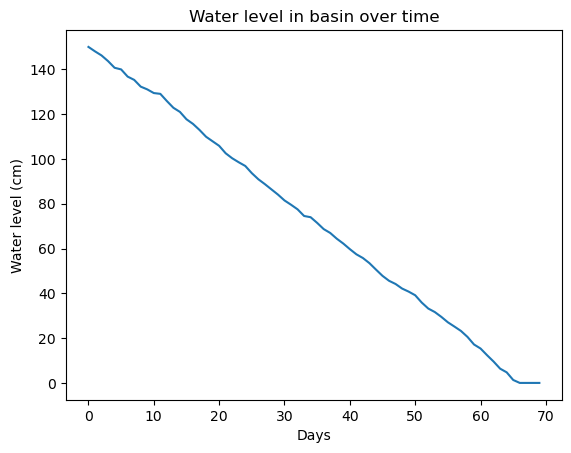

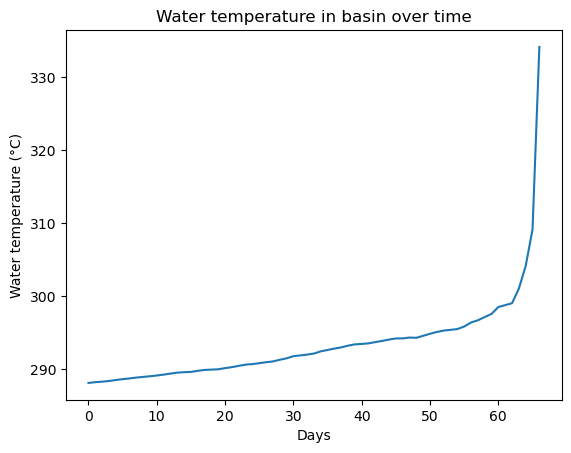

In [102]:
plot_data(z_w, "Water level (cm)", "Water level in basin over time")
plot_data(t_w, "Water temperature (°C)", "Water temperature in basin over time")

Create a DataFrame with the output data

In [103]:
output_data = pd.DataFrame({"Day": range(1, days + 1),
                            "Temperature (°C)": t_w,
                            "Water Level (cm)": z_w,
                            "Water amount (L)": z_w * basin_surface_area})

Save the DataFrame as a CSV file

In [104]:
output_data.to_csv("scenario_floodplain.csv", index=False)